# Ocean temperatures: AXBTs and SWIFT buoys

During EUREC4A/ATOMIC the P-3 deployed 165 Airborne eXpendable BathyThermographs (AXBTs)
to measure profiles of ocean temperature. (These are kind of the oceanic equivalent of
dropsondes but they don't measure salinity.) Often these were dropped around
other ocean temperature measurements - for example the autonomous
Surface Wave Instrument Floats with Tracking (SWIFT) buoys deployed from the
Ron Brown by Elizabeth Thompson of NOAA and her colleagues. The SWIFT deployment
is described in {cite}`Quinn:2021`.

Let's take a look at some of the AXBT measurements and how they compare to the
SWIFTs.

In [1]:
import xarray as xr
import numpy as np
import datetime

import matplotlib.pyplot as plt
plt.style.use(["./mplstyle/book"])
%matplotlib inline

import eurec4a
cat = eurec4a.get_intake_catalog()

Mapping takes quite some setup. Maybe we'll encapsulate this later but for now we repeat code
in each notebook.

In [2]:
import matplotlib as mpl
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
from   cartopy.feature import LAND
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
def ax_to_map(ax, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    # Defining boundaries of the plot
    ax.set_extent([lon_w,lon_e,lat_s,lat_n]) # lon west, lon east, lat south, lat north
    ax.coastlines(resolution='10m',linewidth=1.5,zorder=1);
    ax.add_feature(LAND,facecolor='0.9')

def set_up_map(plt, lon_w = -60.5, lon_e = -49, lat_s = 10, lat_n = 16.5):
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax_to_map(ax, lon_w, lon_e, lat_s, lat_n)
    return(ax)

def add_gridlines(ax):
    # Assigning axes ticks
    xticks = np.arange(-65,0,2.5)
    yticks = np.arange(0,25,2.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1,
                      color='black', alpha=0.5, linestyle='dotted')
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    gl.right_labels = False
    gl.bottom_labels = False
    gl.xlabel = {'Latitude'}

What days did the P-3 fly on? We can find out via the flight segmentation files.

In [3]:
# On what days did the P-3 fly? These are UTC date
all_flight_segments = eurec4a.get_flight_segments()
flight_dates = np.unique([np.datetime64(flight["takeoff"]).astype("datetime64[D]")
                          for flight in all_flight_segments["P3"].values()])

Now set up colors to code each flight date during the experiment. One could choose
a categorical palette so the colors were as different from each other as possible.
Here we'll choose from a continuous set that spans the experiment so days that are
close in time are also close in color.

In [4]:
# Like mpl.colors.Normalize but works also with datetime64 objects
def mk_norm(vmin, vmax):
    def norm(values):
        return (values - vmin) / (vmax - vmin)
    return norm
norm = mk_norm(np.datetime64("2020-01-15"),
               np.datetime64("2020-02-15"))

# color map for things coded by flight date
#   Sample from a continuous color map running from start to end of experiment
def color_of_day(day):
    return plt.cm.viridis(norm(day), alpha=0.9)

The P-3 only deployed AXBTs on some flights, and the SWIFT buoys were only deployed
on a subset of those dates.

In [5]:
axbts = cat.P3.AXBT.Level_3.to_dask()
swifts = [cat[s].all.to_dask() for s in list(cat) if "SWIFT" in s]
axbt_dates = np.intersect1d(np.unique(axbts.time.astype("datetime64[D]").values),
                            flight_dates)

swift_candidates = np.unique(np.concatenate([swift.time.astype('datetime64[D]').values
                                             for swift in swifts]))
# Dates with potential SWIFT/P-3 overlap
swift_dates = np.intersect1d(swift_candidates, axbt_dates)

For plotting purposes it'll be handy to define a one-day time window and to convert between date/time formats

In [6]:
one_day = np.timedelta64(1, "D")

def to_datetime(dt64):
    epoch = np.datetime64("1970-01-01")
    second = np.timedelta64(1, "s")
    return datetime.datetime.utcfromtimestamp((dt64 - epoch) / second)

Now we can make a map that shows where the AXBTs were deployed and where the SWIFTs
were on days there the two platforms overlapped

/usr/share/miniconda/envs/how_to_eurec4a/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


/usr/share/miniconda/envs/how_to_eurec4a/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


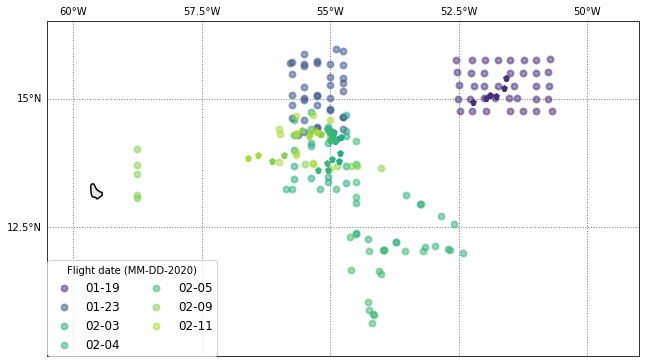

In [7]:
fig = plt.figure(figsize = (8.3, 9.4))
ax  = set_up_map(plt)
add_gridlines(ax)

#
# AXBT locations
#
for d in axbt_dates:
    flight = axbts.sel(time=slice(d, d + one_day))
    ax.scatter(flight.lon, flight.lat,
               lw=2, alpha=0.5, color=color_of_day(d),
               transform=ccrs.PlateCarree(), zorder=7,
               label=f"{to_datetime(d):%m-%d}")

#
# SWIFT locations on selected dates (where there's overlap)
#
for d in swift_dates:
    flight = axbts.sel(time=slice(d, d + one_day))
    for swift in swifts:
        drift = swift.sel(time = flight.time.mean(), method = "nearest")
        ax.scatter(drift.lon, drift.lat,
                   alpha=1, color=color_of_day(d),
                   transform=ccrs.PlateCarree(), zorder=7, marker = "p")

plt.legend(ncol=2,loc=(0.0,0.0),fontsize=12,framealpha=0.8,markerscale=1,
           title="Flight date (MM-DD-2020)")

On 19 Jan and 3 Feb the AXBTs bracket the SWIFTs; on 23 Jan the SWIFTs are at
the southern end of the AXBT pattern.

The next plot will focus on 19 Jan.
Let's look at the profile of ocean temperature in the first 150 m from the AXBTs
and compare the near-surface temperatures to the SWIFTs they are surrounding.

(<matplotlib.patches.Rectangle at 0x7f1f575d5a90>,
 (<matplotlib.patches.ConnectionPatch at 0x7f1f574d8bb0>,
  <matplotlib.patches.ConnectionPatch at 0x7f1f574e2610>))

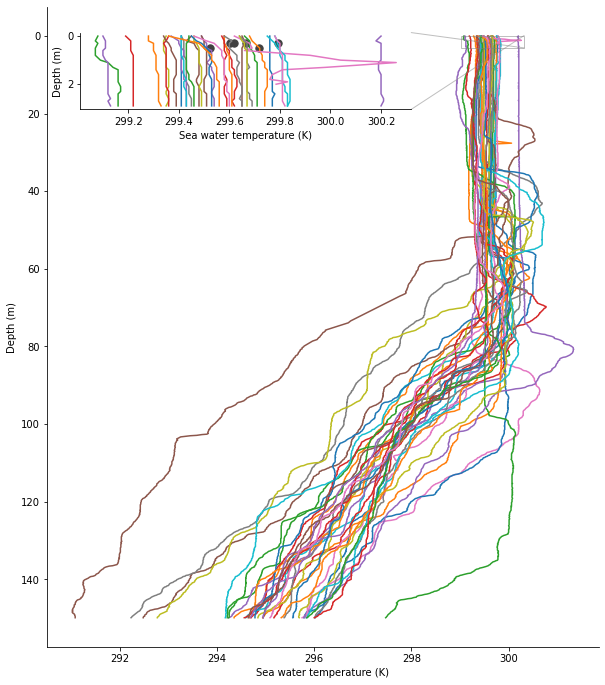

In [8]:
fig, ax = plt.subplots(figsize=[8.3, 9.4])
d = np.datetime64("2020-01-19")
axbt_1day   = axbts.sel(time=slice(d, d + one_day))
# Swift data at mean of AXBT times
swifts_1day = [s.sel(time = axbt_1day.time.mean(), method = "nearest") for s in swifts]

axbt_1day.temperature.where(axbt_1day.depth < 150).plot.line(y="depth",
                                                             add_legend=False, yincrease=False)
ax.set_xlabel("Sea water temperature (K)")
ax.set_ylabel("Depth (m)")

#
# Inset plot! https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/zoom_inset_axes.html
#
axin = ax.inset_axes([0.06, 0.84, 0.6, 0.12])
axin.scatter([s.sea_water_temperature.values + 273.15 for s in swifts_1day],
             # SWIFTs 16 and 17 report water temperature at 0.5 m depth; SWIFTs 23-25 report at 0.3 m
             # See the variable long_name or  Tables 8 and 9 of Quinn et al.
             [0.5 if '0.5' in s.sea_water_temperature.long_name else 0.3 for s in swifts_1day],
             color="0.25",
             s = 1.5 * plt.rcParams['lines.markersize'] ** 2)
axbt_1day.temperature.where(axbt_1day.depth < 3).plot.line(y="depth",
                                                           add_legend=False,
                                                           yincrease=False, ax = axin)
axin.set_xlabel("Sea water temperature (K)")
axin.set_ylabel("Depth (m)")
ax.indicate_inset_zoom(axin)